## Core Workflow: Download Sentinel-1 and Sentinel-2 images
Purpose: Search and acquire Sentinel-1 and Sentinel-2 images for a given studay area and time period. The acquired images can be inspected for conditions such as cloud cover, haziness etc. Finally, the acquired images can be downloaded and stored in the path.
<br>
Requirements: This notebook uses `bronco.py` and `bronco_candidates.py`
<br>
<br>
*Date: 2018-09-12*
<br>
*Author: Taufiq Rashid*


### Import statements

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import bronco
import bronco_candidates
reload(bronco)
reload(bronco_candidates)

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


<module 'bronco_candidates' from '/home/Peter.Kerins/UrbanLandUse/utils/bronco_candidates.pyc'>

### Set key variables

In [2]:
place = 'hyderabad'  # setting the study area

data_root='/data/phase_iii/'
data_path=data_root+place+'/'  

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'  
s1_resolution = 10  

### Load and inspect study area 

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

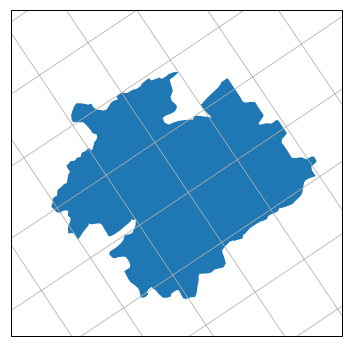

In [3]:
print place, place.title()  # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

bronco_candidates.info_studyareas(data_path, place)

shape = bronco_candidates.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
bbox = shape['bbox']

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (bbox[0]+bbox[2])/2.0, (bbox[1]+bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile000 {u'type': u'Polygon', u'coordinates': [[[78.13077314139645, 17.436029491683943], [78.15785947221487, 17.43641812209065], [78.15745617371114, 17.46241865708724], [78.13036601215559, 17.462029411047467], [78.13077314139645, 17.436029491683943]]]}


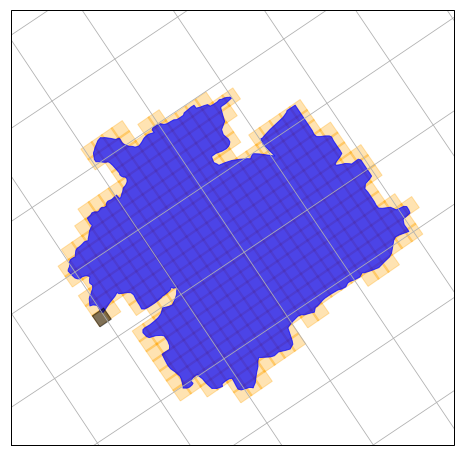

In [4]:
single_tile_id = 22
tiles = dl.raster.dltiles_from_shape(10.0, 256, 16, shape) 
bronco_candidates.draw_tiled_area(shape, tiles, albers, lonlat_crs)

### Search and acquire sentinel-2 imagery 

In [5]:
product = u'sentinel-2:L1C'
satellite='S2A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-10-01', end_time='2017-11-01', 
                                        cloud_fraction_0=0.5, limit=75, geom=shape['geometry'])
s2_ids = [f['id'] for f in feature_collection['features']]
s2_ids.sort()
print len(s2_ids), s2_ids


54 [u'sentinel-2:L1C:2016-10-06_43QHV_58_S2A_v1', u'sentinel-2:L1C:2016-10-16_43QHV_96_S2A_v1', u'sentinel-2:L1C:2016-10-16_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-10-26_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-10-26_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-10-29_43QHV_30_S2A_v1', u'sentinel-2:L1C:2016-11-05_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-11-05_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-11-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-11-15_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-11-25_43QHV_98_S2A_v1', u'sentinel-2:L1C:2016-11-25_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-05_43QHV_98_S2A_v1', u'sentinel-2:L1C:2016-12-05_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-15_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-25_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-25_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-28_43QHV_30_S2A_v1', u'sentinel-2:L1C:2017-01-04_43QHV_38_S2A_v1', u'sentinel-2:L1C:2017-01-04_44QKE_48_S2A_v1', u'sentinel-2:L1C:2017-01-07_43

### View image extents

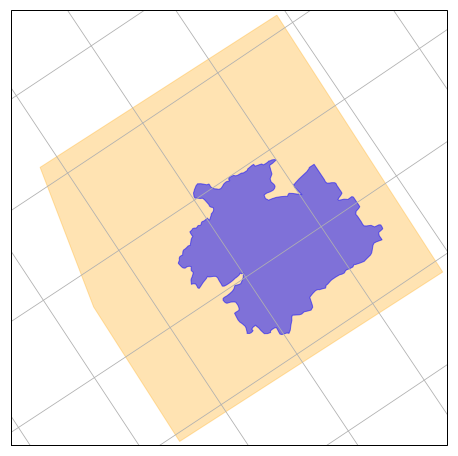

In [6]:
s2_imgs = s2_ids[6:7]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

shapes = []
for s2_img in s2_imgs:
    metadata = dl.metadata.get(s2_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')
ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()


### Inspect imagery

[u'sentinel-2:L1C:2016-11-05_43QHV_97_S2A_v1'] (787, 841, 4)


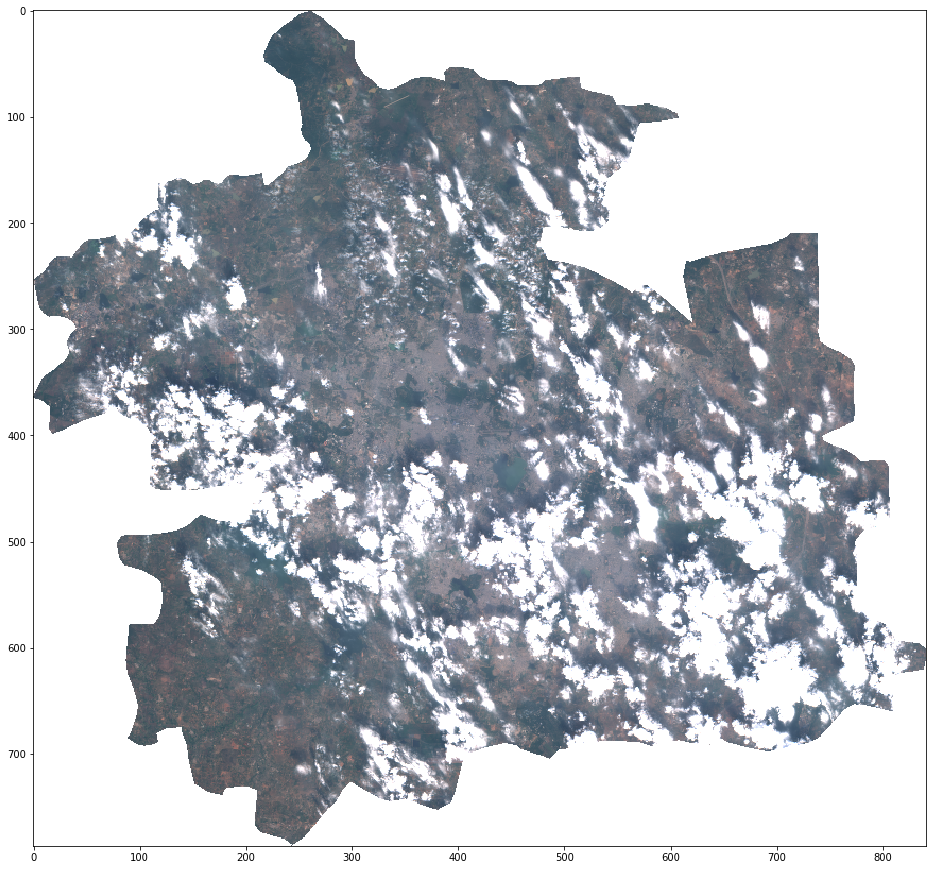

In [7]:
bronco.show_scene(s2_imgs[:],bands=['red','green','blue','alpha'],scales=[[0,3000],[0,3000],[0,3000],], geom=shape['geometry'], resolution=80)

### Download imagery 


In [10]:
# pull from api and save to file tiled images: sentinel-2 vir
s2_dict = {}
#s2_dict['O'] = [u'sentinel-2:L1C:2017-05-14_43QHV_98_S2A_v1'] 
#s2_dict['P'] = [u'sentinel-2:L1C:2017-11-10_43QHV_56_S2A_v1', u'sentinel-2:L1C:2017-11-10_43QHV_58_S2A_v1'] 
#s2_dict['Q'] = [u'sentinel-2:L1C:2017-11-30_43QHV_97_S2A_v1']
#s2_dict['R'] = [u'sentinel-2:L1C:2017-12-15_43QHV_97_S2B_v1']
#s2_dict['S'] = [u'sentinel-2:L1C:2017-12-20_43QHV_97_S2A_v1']
#s2_dict['T'] = [u'sentinel-2:L1C:2017-12-25_43QHV_97_S2B_v1']
#s2_dict['U'] = [u'sentinel-2:L1C:2018-01-04_43QHV_97_S2B_v1']
#s2_dict['V'] = [u'sentinel-2:L1C:2018-01-14_43QHV_97_S2B_v1']
#s2_dict['W'] = [u'sentinel-2:L1C:2018-01-24_43QHV_97_S2B_v1'] 
#s2_dict['X'] = [u'sentinel-2:L1C:2018-01-29_43QHV_97_S2A_v1']
#s2_dict['Y'] = [u'sentinel-2:L1C:2018-02-03_43QHV_97_S2B_v1']
#s2_dict['Z'] = [u'sentinel-2:L1C:2018-02-08_43QHV_97_S2A_v1']
s2_dict['AA'] = [u'sentinel-2:L1C:2018-02-18_43QHV_97_S2A_v1']
#s2_dict['AB'] = [u'sentinel-2:L1C:2018-02-23_43QHV_97_S2B_v1']
#s2_dict['AC'] = [u'sentinel-2:L1C:2018-02-28_43QHV_97_S2A_v1']
#s2_dict['AD'] = [u'sentinel-2:L1C:2018-03-05_43QHV_97_S2B_v1'] 
#s2_dict['AE'] = [u'sentinel-2:L1C:2018-03-10_43QHV_97_S2A_v1']
#s2_dict['AF'] = [u'sentinel-2:L1C:2018-03-25_43QHV_97_S2B_v1']
#s2_dict['AG'] = [u'sentinel-2:L1C:2018-03-30_43QHV_97_S2A_v1']
#s2_dict['AH'] = [u'sentinel-2:L1C:2018-04-04_43QHV_97_S2B_v1']
#s2_dict['AI'] = [u'sentinel-2:L1C:2018-04-09_43QHV_97_S2A_v1']
#s2_dict['AJ'] = [u'sentinel-2:L1C:2018-04-14_43QHV_97_S2B_v1'] 
#s2_dict['AK'] = [u'sentinel-2:L1C:2018-04-24_43QHV_97_S2B_v1'] 
#s2_dict['AL'] = [u'sentinel-2:L1C:2018-04-29_43QHV_97_S2A_v1']
#s2_dict['AM'] = [u'sentinel-2:L1C:2018-05-09_43QHV_97_S2A_v1']
#s2_dict['AN'] = [u'sentinel-2:L1C:2018-05-14_43QHV_97_S2B_v1']
#s2_dict['AO'] = [u'sentinel-2:L1C:2018-05-19_43QHV_97_S2A_v1']
#s2_dict['AP'] = [u'sentinel-2:L1C:2018-05-29_43QHV_97_S2A_v1']
#s2_dict['AQ'] = [u'sentinel-2:L1C:2018-09-11_43QHV_97_S2B_v1'] 


continue_index = 0

for vir_suffix, s2_imgs in s2_dict.items():
    print vir_suffix, s2_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download VIR image'
        vir_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_vir_'+vir_suffix
        print vir_band_file
        vir = dl.raster.raster(
                s2_imgs,
                bands=bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=vir_band_file)

AA [u'sentinel-2:L1C:2018-02-18_43QHV_97_S2A_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_AA
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_AA
tile 2 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile002_vir_AA
tile 3 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile003_vir_AA
tile 4 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile004_vir_AA
tile 5 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile005_vir_AA
tile 6 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile006_vir_AA
tile 7 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile007_vir_AA
tile 8 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile008_vir_AA
tile 9 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile009_vir_AA
tile 10 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile010_vir_AA
tile 11 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile011_vir_AA
tile 12 download VIR ima

tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_AA
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_AA
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_AA
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile108_vir_AA
tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile109_vir_AA
tile 110 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile110_vir_AA
tile 111 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile111_vir_AA
tile 112 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile112_vir_AA
tile 113 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile113_vir_AA
tile 114 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile114_vir_AA
tile 115 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile115_vir_AA
tile 116 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile116_vir_AA
tile 117 download VIR image
/data/phase_iii/hyderaba

tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_AA
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_AA
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_AA
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_AA
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_AA
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_AA
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile215_vir_AA
tile 216 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile216_vir_AA
tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_AA
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile218_vir_AA
tile 219 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile219_vir_AA
tile 220 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile220_vir_AA
tile 221 download VIR image
/data/phase_iii/hyderaba

tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_AA
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_AA
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_AA
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_AA
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_AA
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_AA
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_AA
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_AA
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_AA
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_AA
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_AA
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile324_vir_AA
tile 325 download VIR image
/data/phase_iii/hyderaba

tile 417 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile417_vir_AA
tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_AA
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_AA
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_AA
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_AA
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_AA
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_AA
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_AA
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_AA
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_AA
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_AA
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_AA
tile 429 download VIR image
/data/phase_iii/hyderaba

### Adjusting image files for UTM zone

In [ ]:
for tile_id in range(len(tiles['features'])):
    os.environ['ZRESULTTILE'] = data_path+place+'_tile'+str(tile_id).zfill(4)+'_vir_'+vir_suffix+'.tif' 
    !gdalinfo -proj4 $ZRESULTTILE | grep PROJCS

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    !gdalwarp -t_srs '+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs ' $ZTILESOURCE $ZTILERESULT

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    !mv $ZTILESOURCE $ZTILERESULT

### Mosaic the set of images

In [ ]:
!gdal_merge.py -n 255 -a_nodata 255 -o /data/steven/data/houston/houston_vir_before.tif /data/steven/data/houston/houston_tile????_vir_before.tif


### Search and acquire sentinel-1 imagery 

In [11]:
product= u'sentinel-1:GRD'
s1_satellite='SENTINEL-1A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-01-01', end_time='2016-01-20', 
                                        limit=75, geom=shape['geometry'])
s1_ids = [f['id'] for f in feature_collection['features']]
s1_ids.sort()
print len(s1_ids), s1_ids

4 [u'sentinel-1:GRD:meta_2016-01-04_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-04_165D3854_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']


### View image extents

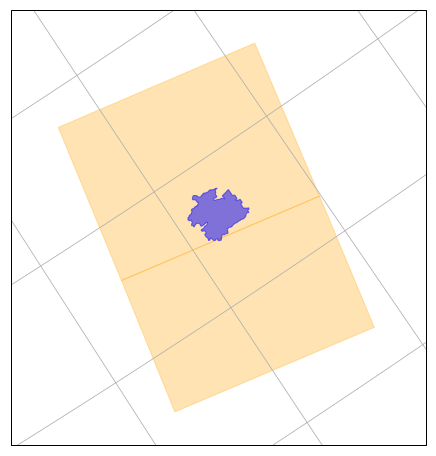

In [12]:
s1_imgs = s1_ids[2:4]
# view image extents 
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

# Get the geometry from each feature
shapes = []
for s1_img in s1_imgs:
    metadata = dl.metadata.get(s1_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')

ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
ax.set_extent((union.bounds[0], union.bounds[2], union.bounds[1], union.bounds[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()

### Inspect imagery

[u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A'] (785, 833, 3)


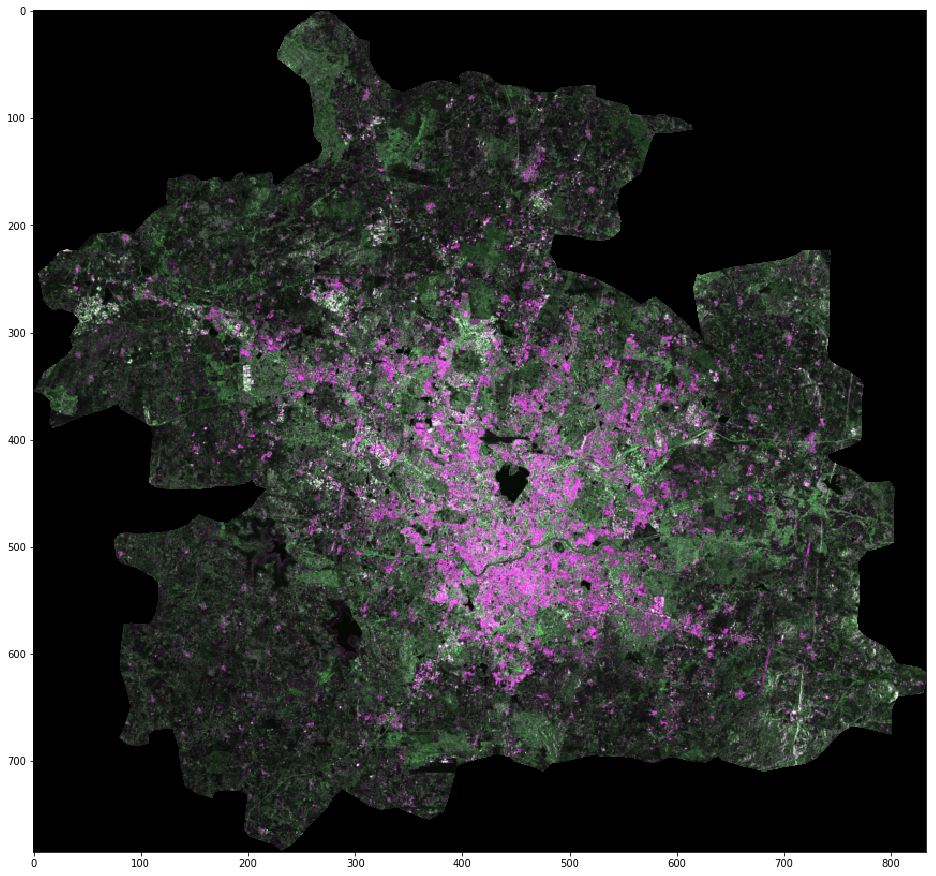

In [13]:
bronco.show_scene(s1_imgs[:], geom=shape['geometry'], resolution=80,bands=['vv','vh','vv'],scales=[[0,255],[0,255],[0,255]])

### Download imagery


In [15]:
# pull from api and save to file tiled images: sentinel-1 sar
s1_dict = {}
#s1_dict['A'] = [u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']
#s1_dict['B'] = [u'sentinel-1:GRD:meta_2016-02-09_165D3826_S1A', u'sentinel-1:GRD:meta_2016-02-09_165D3853_S1A']
#s1_dict['C'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
#s1_dict['D'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
#s1_dict['E'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
#s1_dict['F'] = [u'sentinel-1:GRD:meta_2016-10-18_165D3839_S1A']
#s1_dict['G'] = [u'sentinel-1:GRD:meta_2016-10-30_165D3839_S1A']
#s1_dict['H'] = [u'sentinel-1:GRD:meta_2016-11-23_165D3839_S1A']
#s1_dict['I'] = [u'sentinel-1:GRD:meta_2016-12-17_165D3838_S1A']
#s1_dict['J'] = [u'sentinel-1:GRD:meta_2016-12-29_165D3838_S1A']
#s1_dict['K'] = [u'sentinel-1:GRD:meta_2017-02-03_165D3836_S1A']
#s1_dict['L'] = [u'sentinel-1:GRD:meta_2017-02-27_165D3834_S1A']
#s1_dict['M'] = [u'sentinel-1:GRD:meta_2017-04-04_165D3838_S1A']
#s1_dict['N'] = [u'sentinel-1:GRD:meta_2017-04-28_165D3839_S1A']
#s1_dict['O'] = [u'sentinel-1:GRD:meta_2017-05-10_165D3839_S1A']
#s1_dict['P'] = [u'sentinel-1:GRD:meta_2017-11-06_165D3847_S1A'] 
#s1_dict['Q'] = [u'sentinel-1:GRD:meta_2017-11-30_165D3846_S1A']
#s1_dict['R'] = [u'sentinel-1:GRD:meta_2017-12-12_165D3846_S1A']
#s1_dict['S'] = [u'sentinel-1:GRD:meta_2017-12-24_165D3845_S1A']
#s1_dict['T'] = [u'sentinel-1:GRD:meta_2017-12-24_165D3845_S1A']
#s1_dict['U'] = [u'sentinel-1:GRD:meta_2018-01-05_165D3845_S1A']
#s1_dict['V'] = [u'sentinel-1:GRD:meta_2018-01-17_165D3844_S1A']
#s1_dict['W'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A'] 
#s1_dict['X'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A'] 
#s1_dict['Y'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A']
#s1_dict['Z'] = [u'sentinel-1:GRD:meta_2018-02-10_165D3844_S1A']
s1_dict['AA'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
#s1_dict['AB'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
#s1_dict['AC'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
#s1_dict['AD'] = [u'sentinel-1:GRD:meta_2018-03-06_165D3843_S1A']
#s1_dict['AE'] = [u'sentinel-1:GRD:meta_2018-03-06_165D3843_S1A']
#s1_dict['AF'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
#s1_dict['AG'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
#s1_dict['AH'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
#s1_dict['AI'] = [u'sentinel-1:GRD:meta_2018-04-11_165D3844_S1A']
#s1_dict['AJ'] = [u'sentinel-1:GRD:meta_2018-04-11_165D3844_S1A']
#s1_dict['AK'] = [u'sentinel-1:GRD:meta_2018-04-23_165D3845_S1A'] 
#s1_dict['AL'] = [u'sentinel-1:GRD:meta_2018-04-23_165D3845_S1A']
#s1_dict['AM'] = [u'sentinel-1:GRD:meta_2018-05-05_165D3845_S1A']
#s1_dict['AN'] = [u'sentinel-1:GRD:meta_2018-05-17_165D3846_S1A']
#s1_dict['AO'] = [u'sentinel-1:GRD:meta_2018-05-17_165D3846_S1A']
#s1_dict['AP'] = [u'sentinel-1:GRD:meta_2018-05-29_165D3847_S1A']
#s1_dict['AQ'] = [u'sentinel-1:GRD:meta_2018-09-02_165D3852_S1A']
 

for sar_suffix, s1_imgs in s1_dict.items():
    print sar_suffix, s1_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download SAR image'
        sar_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_sar_'+sar_suffix
        print sar_band_file
        sar = dl.raster.raster(
                s1_imgs,
                bands=s1_bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=sar_band_file)

AA [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_AA
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_AA
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_AA
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_AA
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_AA
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_AA
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_AA
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_AA
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_AA
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_AA
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_AA
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_AA
tile 12 download SAR i

tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_AA
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_AA
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_AA
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_AA
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_AA
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_AA
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_AA
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_AA
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_AA
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_AA
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_AA
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_AA
tile 117 download SAR image
/data/phase_iii/hyderaba

tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_AA
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_AA
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_AA
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_AA
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_AA
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_AA
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_AA
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_AA
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_AA
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_AA
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_AA
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_AA
tile 222 download SAR image
/data/phase_iii/hyderaba

tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_AA
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_AA
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_AA
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_AA
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_AA
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_AA
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_AA
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_AA
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_AA
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_AA
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_AA
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_AA
tile 327 download SAR image
/data/phase_iii/hyderaba

tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_AA
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_AA
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_AA
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_AA
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_AA
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_AA
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_AA
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_AA
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_AA
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_AA
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_AA
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_AA
tile 431 download SAR image
/data/phase_iii/hyderaba